In [37]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm
import pickle
from astropy import table
from astropy.table import Table, unique, join

In [10]:
import warnings
warnings.filterwarnings("ignore")

## Importfing modules and functions

In [14]:
## Getting geometric fraction. Based on Zhiwei's code. 

import astropy.units as u
from astropy import table
from astropy.table import Table, vstack, unique
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18, FlatLambdaCDM
from scipy.spatial import KDTree
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import tables
import pickle
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import emcee
import tqdm

In [15]:
def spherical_to_cartesian(ra, dec):
    """
    Calculate cartesian coordinates on a unit sphere given two angular coordinates.
    parameters

    Parameters
    -----------
    ra : array
        Angular coordinate in degrees

    dec : array
        Angular coordinate in degrees

    Returns
    --------
    x,y,z : sequence of arrays
        Cartesian coordinates.

    Examples
    ---------
    >>> ra, dec = 0.1, 1.5
    >>> x, y, z = spherical_to_cartesian(ra, dec)

    """

    rar = np.radians(ra)
    decr = np.radians(dec)

    x = np.cos(rar) * np.cos(decr)
    y = np.sin(rar) * np.cos(decr)
    z = np.sin(decr)

    return x, y, z

## BGS Catalog

In [61]:
with open('bgs_clus_RM_gal_matched.pickle', 'rb') as handle:
    bgs_matched = pickle.load(handle)

In [64]:
bgs_matched.remove_column('geoFrac')

## RM Catalog

In [49]:
###File directory
desiDir = '/global/cfs/cdirs/desi/survey/catalogs/dr1/LSS/iron/LSScats/v1.5pip/'
with open('bgs_clus_RM_gal_matched.pickle', 'rb') as handle:
    bgs_matched = pickle.load(handle)
rm_clus = unique(bgs_matched, keys='ID')

## Import the halo catalog
aper = 1.5 # units: Mpc/h
randDensity = 2500 #random points per sq. deg
h = Planck18.H(0).value
rad2deg= 57.2958
arcsec2deg = 1./3600.

##Should there be a Hubble scaling??
rm_clus['angRad'] = aper*(Planck18.arcsec_per_kpc_comoving(rm_clus['Z_SPEC_x']).value*1000)*arcsec2deg
#rm_clus['D_comoving'] = Planck18.comoving_distance(rm_clus_matched['Z_SPEC_x']) #Should multiple by hubble?
rm_clus['pos'] = np.array(spherical_to_cartesian(rm_clus['RA_x'], rm_clus['DEC_x'])).T
#rm_clus[f'{aper}Mpc_arc'] = aper/rm_clus['D_comoving']
rm_clus['sq_deg'] = np.pi*rm_clus['angRad']**2
rm_clus[f'Nr_{aper}Mpc_expected'] = rm_clus['sq_deg']*randDensity
rm_clus['geoFrac'] = 0.


## Random geometric fraction pipeline

In [51]:
numRand = 18
for i in range(numRand):
    randomCat = "BGS_ANY_{}_full_HPmapcut.ran.fits".format(i)
    print(randomCat)
    ran_data = Table.read(desiDir + randomCat)
    ran_data['pos'] = np.array(spherical_to_cartesian(ran_data['RA'], ran_data['DEC'])).T

    # Constructing KDTree for pair counting
    rtree = KDTree(ran_data['pos'])

    # Number of random points
    rm_clus[f"Nr_{aper}Mpc"] = np.asarray(rtree.query_ball_point(rm_clus['pos'].data, \
                                            rm_clus['angRad']/rad2deg, workers=100, return_length=True), dtype=float)
    rm_clus['geoFrac'] += rm_clus[f"Nr_{aper}Mpc"]/rm_clus[f'Nr_{aper}Mpc_expected']

rm_clus['geoFrac'] /= numRand

BGS_ANY_0_full_HPmapcut.ran.fits
BGS_ANY_1_full_HPmapcut.ran.fits
BGS_ANY_2_full_HPmapcut.ran.fits
BGS_ANY_3_full_HPmapcut.ran.fits
BGS_ANY_4_full_HPmapcut.ran.fits
BGS_ANY_5_full_HPmapcut.ran.fits
BGS_ANY_6_full_HPmapcut.ran.fits
BGS_ANY_7_full_HPmapcut.ran.fits
BGS_ANY_8_full_HPmapcut.ran.fits
BGS_ANY_9_full_HPmapcut.ran.fits
BGS_ANY_10_full_HPmapcut.ran.fits
BGS_ANY_11_full_HPmapcut.ran.fits
BGS_ANY_12_full_HPmapcut.ran.fits
BGS_ANY_13_full_HPmapcut.ran.fits
BGS_ANY_14_full_HPmapcut.ran.fits
BGS_ANY_15_full_HPmapcut.ran.fits
BGS_ANY_16_full_HPmapcut.ran.fits
BGS_ANY_17_full_HPmapcut.ran.fits


In [52]:
numRand = 1
randomCat = "BGS_ANY_{}_full_HPmapcut.ran.fits".format(i)

ran_data = Table.read(desiDir + randomCat)
ran_data['pos'] = np.array(spherical_to_cartesian(ran_data['RA'], ran_data['DEC'])).T

# Constructing KDTree for pair counting
rtree = KDTree(ran_data['pos'])

# Number of random points
num_cl_rand = np.asarray(rtree.query_ball_point(rm_clus['pos'].data, \
                                            rm_clus['angRad']/rad2deg, workers=100, return_length=True), dtype=float)
test_geoFrac = num_cl_rand/rm_clus[f'Nr_{aper}Mpc_expected']

## Plotting

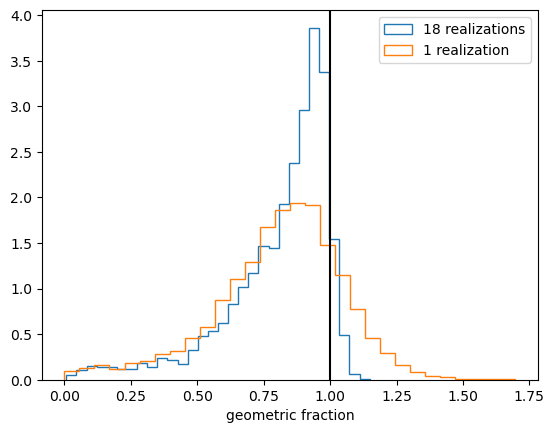

In [53]:
plt.hist(rm_clus['geoFrac'], bins=30, histtype='step', label='18 realizations', density=True)
plt.hist(test_geoFrac, bins=30, histtype='step', label='1 realization', density=True)
plt.axvline(1, color='black')
plt.xlabel('geometric fraction')
plt.legend()
plt.show()

## Match the RM geometric fraction to the BGS_Matched catalog

In [66]:
bgs_matched = join(bgs_matched, rm_clus[['ID', 'geoFrac']], keys='ID', join_type='inner')

In [67]:
bgs_matched[0:5]

TARGETID,RA_BGS,DEC_BGS,Z_BGS,WEIGHT,ID,LAMBDA,Z_LAMBDA,R_LAMBDA,Z_SPEC_x,RA_x,DEC_x,RM_gal_flag,Z_SPEC_y,RA_y,DEC_y,R,P,geoFrac
int64,float64,float64,float64,float64,int32,float32,float32,float64,float32,float64,float64,bool,float64,float64,float64,float64,float64,float64
39628423202606833,239.44814235214548,27.163580786831865,0.3395760549009007,2.000025749206543,1,169.83784,0.09483067,1.1117493745677802,0.09080672,239.5833290688836,27.233412917827273,False,-1.0,-1.0,-1.0,-1.0,-1.0,0.7660373289661593
39628423206801038,239.69617434823417,27.28721706332761,0.21445889411512098,3.0000046491622925,1,169.83784,0.09483067,1.1117493745677802,0.09080672,239.5833290688836,27.233412917827273,False,-1.0,-1.0,-1.0,-1.0,-1.0,0.7660373289661593
39628423206800905,239.68942347094608,27.317718829311953,0.09940091069271458,6.0,1,169.83784,0.09483067,1.1117493745677802,0.09080672,239.5833290688836,27.233412917827273,False,-1.0,-1.0,-1.0,-1.0,-1.0,0.7660373289661593
39628423206800895,239.68918050987529,27.15067062677909,0.08052782733638857,1.000214695930481,1,169.83784,0.09483067,1.1117493745677802,0.09080672,239.5833290688836,27.233412917827273,False,-1.0,-1.0,-1.0,-1.0,-1.0,0.7660373289661593
39628423206800843,239.68678379785,27.25131632288843,0.08172227812353887,4.0,1,169.83784,0.09483067,1.1117493745677802,0.09080672,239.5833290688836,27.233412917827273,False,-1.0,-1.0,-1.0,-1.0,-1.0,0.7660373289661593


## Saving the file

In [68]:
with open('bgs_clus_RM_gal_matched.pickle', 'wb') as handle:
    pickle.dump(bgs_matched, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Old Stuff

## Inputing random mask

Choose 1 of the 18 realizations. They differ in random number counts by $<1\%$

In [11]:
desiDir = '/global/cfs/cdirs/desi/survey/catalogs/dr1/LSS/iron/LSScats/v1.5pip/'
randomCat = 'BGS_ANY_10_full.ran.fits'

In [12]:
ran_data = Table.read(desiDir + randomCat)

In [13]:
ran_data.columns

<TableColumns names=('LOCATION','FIBER','TARGETID','RA','DEC','TILEID','PRIORITY','TSNR2_ELG','TSNR2_LYA','TSNR2_BGS','TSNR2_QSO','TSNR2_LRG','TILELOCID','ZPOSSLOC','GOODHARDLOC','GOODPRI','NTILE','TILES','TILELOCIDS','NOBS_G','NOBS_R','NOBS_Z','MASKBITS','PHOTSYS','HALPHA','HALPHA_ERROR','CALIB_G','CALIB_R','CALIB_Z','EBV_CHIANG_SFDcorr','EBV_MPF_Mean_FW15','EBV_MPF_Mean_ZptCorr_FW15','EBV_MPF_Var_FW15','EBV_MPF_VarCorr_FW15','EBV_MPF_Mean_FW6P1','EBV_MPF_Mean_ZptCorr_FW6P1','EBV_MPF_Var_FW6P1','EBV_MPF_VarCorr_FW6P1','EBV_SGF14','BETA_ML','BETA_MEAN','BETA_RMS','HI','KAPPA_PLANCK','STARDENS','PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','PSFDEPTH_W1','PSFDEPTH_W2','PSFSIZE_G','PSFSIZE_R','PSFSIZE_Z','EBV','FRAC_TLOBS_TILES')>

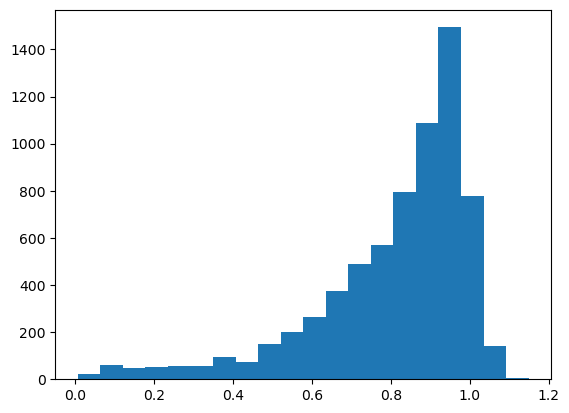

In [17]:
rm_clus['geoFrac'] += rm_clus[f'Nr_{aper}Mpc_expected']/rm_clus[f'Nr_{aper}Mpc_expected']

In [18]:
h = Planck18.H(0).value

### Input the matched BGS_RM catalog

In [8]:
with open('bgs_clus_RM_gal_matched.pickle', 'rb') as handle:
    bgs_matched = pickle.load(handle)

In [9]:
rm_clus = unique(bgs_matched, keys='ID')

In [ ]:
## Zhiwei's code

import astropy.units as asu
from astropy.table import Table, vstack
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from scipy.spatial import KDTree

def spherical_to_cartesian(ra, dec):
    """
    Calculate cartesian coordinates on a unit sphere given two angular coordinates.
    parameters

    Parameters
    -----------
    ra : array
        Angular coordinate in degrees

    dec : array
        Angular coordinate in degrees

    Returns
    --------
    x,y,z : sequence of arrays
        Cartesian coordinates.

    Examples
    ---------
    >>> ra, dec = 0.1, 1.5
    >>> x, y, z = spherical_to_cartesian(ra, dec)

    """

    rar = np.radians(ra)
    decr = np.radians(dec)

    x = np.cos(rar) * np.cos(decr)
    y = np.sin(rar) * np.cos(decr)
    z = np.sin(decr)

    return x, y, z

cosmo = FlatLambdaCDM(Om0=.3, H0=100)

# Stack 5 randoms
rand = []
for i in range(5):
    tr = Table.read(f"/home/zwshao/Data/DESI/Y1/BGS/SMHM_cat/Y1LSScat_default/BGS_BRIGHT_{i}_clustering.ran.fits")
    rand.append(tr)
rand = vstack(rand)
rand['pos'] = np.array(spherical_to_cartesian(rand['RA'], rand['DEC'])).T

# Constructing KDTree for pair counting
rtree = KDTree(rand['pos'])

# redshift limits of the groups to use
grpzmin, grpzmax = .1, .4

# Load group data
Mhmin = 13.0
grp = Table.read(f"/home/zwshao/Data/DESI/Y3/YangGroup/v2/DESIDR9Y3_NSGC_BCG_logMh>12.5.hdf5")
grp.rename_columns(['ragroup', 'decgroup', 'logMh'], ['ra_lwc', 'dec_lwc', 'Mh_L'])
grp['ra_bcg'] = grp['ra']
grp['dec_bcg'] = grp['dec']
grp = grp[(grp['z'] >= grpzmin) & (grp['z'] <= grpzmax) & (grp['Mh_L'] > Mhmin)]
grp['pos'] = np.array(spherical_to_cartesian(grp['ra'], grp['dec'])).T

# Define aperture for geoFrac calculation
aper = 1.5 # units: Mpc/h

grp['D_comoving'] = cosmo.comoving_distance(grp['z']).value*cosmo.h

# Convert physical aperture to angular diameters
grp[f'{aper}Mpc_arc'] = aper/grp['D_comoving']
grp[f'{aper}Mpc_theta'] = 2*np.arcsin(aper/grp['D_comoving']/2.) #Aper is already radius why divide by 2.
grp[f'{aper}Mpc_theta_deg'] = grp[f'{aper}Mpc_theta'] * asu.rad.to(asu.deg)

# Number of random points
grp[f"Nr_{aper}Mpc"] = rtree.query_ball_point(grp['pos'].data, grp[f"{aper}Mpc_arc"].data, workers=100, return_length=True)

# Number of expected random points
## This is wrong!! Should be (1-cos), there is no square. 
grp[f'Nr_{aper}Mpc_expected'] = 2*np.pi * (1-np.cos(grp[f'{aper}Mpc_theta'])) * asu.rad.to(asu.deg)**2 * 2500 * 5

grp['geoFrac'] = grp[f"Nr_{aper}Mpc"]/grp[f'Nr_{aper}Mpc_expected']

## Match the BGS to the random

In [10]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18

### Match by 2D distance

In [11]:
rm_c = SkyCoord(ra=rm_clus['RA_x']*u.degree, dec=rm_clus['DEC_x']*u.degree)
ran_c = SkyCoord(ra=ran_data['RA'].value*u.degree, dec=ran_data['DEC'].value*u.degree)

In [12]:
## Search around each RM
max_sep = 15 * u.arcmin
idxc, idxcatalog, d2d, d3d = ran_c.search_around_sky(rm_c, max_sep)
np.all(d2d < max_sep)

True

In [13]:
rm_clus_matched = rm_clus[idxc]
ran_matched = ran_data[idxcatalog]

In [14]:
print("Ratio of matched randoms:", len(ran_matched)/len(ran_data))

Ratio of matched randoms: 0.13728031501794538


In [15]:
def haversine(lon1, lat1, lon2, lat2, r=1):
    """
    Calculate the great circle distance in kilometers between two points (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    #r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c*r

In [16]:
r = haversine(ran_matched['RA'], ran_matched['DEC'], rm_clus_matched['RA_x'], rm_clus_matched['DEC_x'])

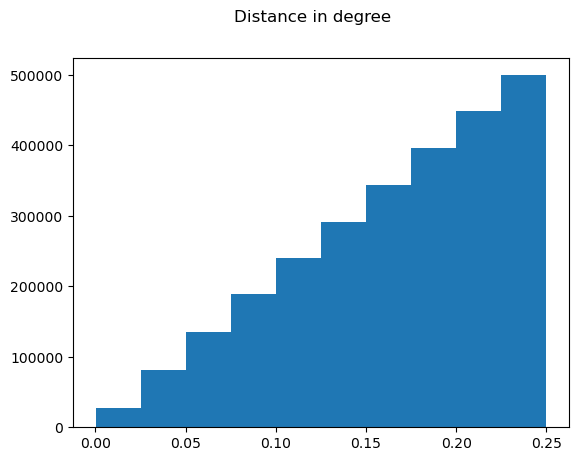

0.2500000823964459

In [17]:
plt.suptitle('Distance in degree')
plt.hist(r*57.2958)
plt.show()
np.max(r*57.2958)

### Then by 3D Distance

In [18]:
##Redshift to distance for random to match the cluster
rm_z = rm_clus_matched['Z_SPEC_x'] * cu.redshift
rand_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

##Redshift to distance for the cluster
rm_z = rm_clus['Z_SPEC_x'] * cu.redshift
rm_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

In [19]:
#Match the galaxy distances on the sky to the matched RM distance

#I think there's a bug in this code. 
rm_c = SkyCoord(ra=rm_clus['RA_x']*u.degree, dec=rm_clus['DEC_x']*u.degree, distance = rm_d)
ran_c = SkyCoord(ra=ran_matched['RA'].value*u.degree, dec=ran_matched['DEC'].value*u.degree, distance = rand_d)

In [20]:
#h = Planck18.H(0).value/100

In [21]:
## Search around each RM
max_sep = 1.5 * u.Mpc 
idxc, idxcatalog, d2d, d3d = ran_c.search_around_3d(rm_c, max_sep)
np.all(d3d < max_sep)

True

In [22]:
print("Ratio = ", len(idxcatalog)/len(ran_matched))

Ratio =  0.1183339521901128


In [23]:
rm_clus_matched = rm_clus[idxc]
ran_matched = ran_matched[idxcatalog]
print("Match rate: ", len(table.unique(rm_clus_matched, keys='ID'))/len(rm_clus)) ##There is a bug here. Why is match rate > 1??

Match rate:  1.0


In [24]:
rm_z = rm_clus_matched['Z_SPEC_x'] * cu.redshift
rand_d = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))

In [25]:
r = haversine(ran_matched['RA'], ran_matched['DEC'], rm_clus_matched['RA_x'], \
              rm_clus_matched['DEC_x'], r=rand_d)

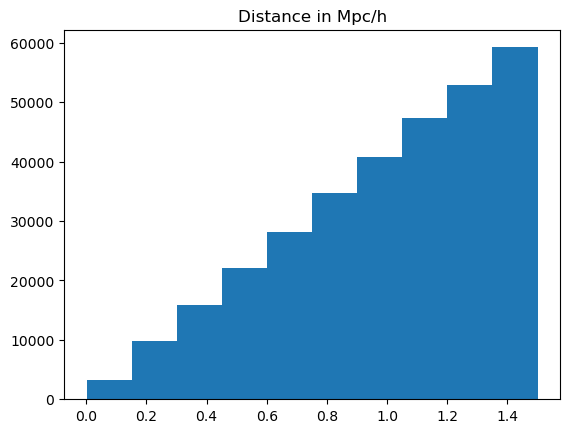

In [26]:
plt.title('Distance in Mpc/h')
plt.hist(r)
plt.show()

In [27]:
np.max(r)

<Quantity 1.49999549 Mpc>

## Geometric weighting
* For the bgs_matched catalog add a column on geometric weighting.
* You still have things leaking outside the radius
  

In [28]:
bgs_matched['geoFrac'] = np.float64(-1.0)

In [29]:
count = rm_clus_matched.group_by('ID')

In [30]:
arcsec2deg = 1./3600
randDensity = 2500.0 #2500 objects per square degree
#h = Planck18.H(0).value/100
matchRad = 1.5 # Matching radius in Mpc/h in comoving distance

for i, group in enumerate(count.groups):
    ID = group[0]['ID']
    redshift = group[0]['Z_SPEC_x']
    angRad = matchRad*(Planck18.arcsec_per_kpc_comoving(redshift).value*1000)*arcsec2deg
    #print("angRad=", angRad)
    angSize = np.pi*angRad**2 ##For planar geometry for small angles. Otherwise formula for conic section.
    #print("lenGroup=", len(group))
    randArea = len(group)/randDensity
    #print("randArea = ", randArea)
    geoFrac = randArea/angSize
    #print("geoFrac=", geoFrac)     

    ##Input into the catalog
    filt = np.where(bgs_matched['ID'] == ID)
    bgs_matched['geoFrac'][filt] = geoFrac

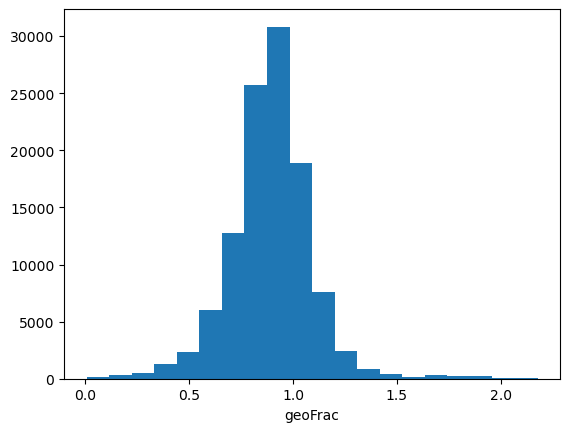

In [31]:
plt.hist(bgs_matched['geoFrac'], bins=20)
plt.xlabel('geoFrac')
plt.show()

## Testing and debugging

Testing whether the random ones fall inside the radius defined by the user. 

In [32]:
rm_clus = unique(bgs_matched, keys='ID')
print('Number of clusters ', len(rm_clus))

Number of clusters  6803


In [33]:
## Testing for geoFrac greater than 1
print('Number of galaxies with geoFrac > 1, ', len(np.where(bgs_matched['geoFrac'] > 1)[0]))
print('Number of clusters with geoFrac > 1, ', len(np.where(rm_clus['geoFrac'] > 1)[0]))
#print(np.where(bgs_matched['geoFrac'] > 1))
#print(np.unique(bgs_matched['ID'][np.where(bgs_matched['geoFrac'] > 1)]))

Number of galaxies with geoFrac > 1,  27081
Number of clusters with geoFrac > 1,  1449


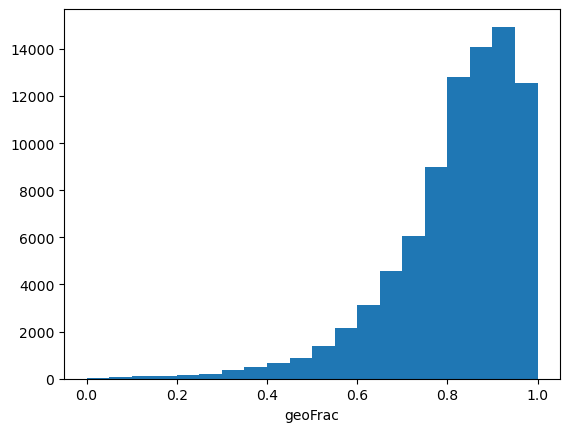

In [34]:
plt.hist(bgs_matched['geoFrac'], bins=20, range=(0,1))
plt.xlabel('geoFrac')
plt.show()

In [35]:
bgs_matched['geoFrac'][np.argmax(bgs_matched['geoFrac'])]

2.176372642550103

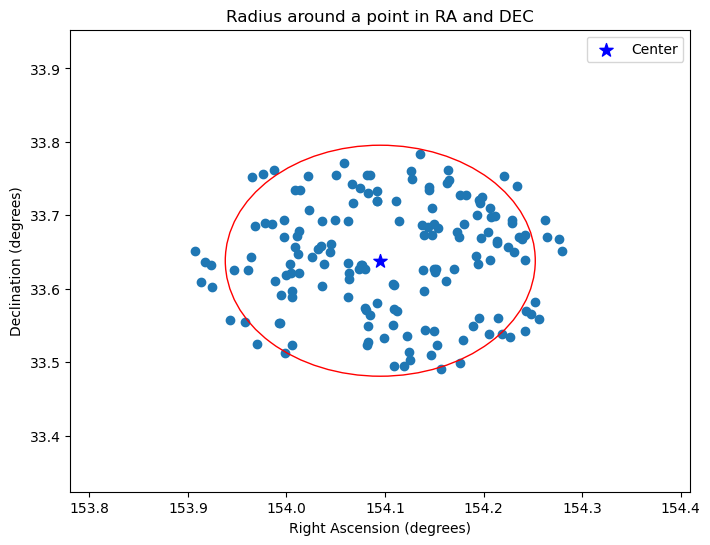

In [51]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(figsize=(8, 6))

testInd=89
test_rand = ran_matched[np.where(idxc == testInd)]

center_ra = rm_clus_matched[np.where(idxc==testInd)]['RA_x'][0] * u.deg
center_dec = rm_clus_matched[np.where(idxc==testInd)]['DEC_x'][0] * u.deg
angDist = matchRad*(Planck18.arcsec_per_kpc_comoving(rm_clus_matched[np.where(idxc==testInd)]['Z_SPEC_x'][0]).value*1000)*arcsec2deg* u.deg


center_coord = SkyCoord(center_ra, center_dec, frame='icrs')
circle = Circle((center_coord.ra.deg, center_coord.dec.deg), \
                angDist.to(u.deg).value, transform=ax.transData, facecolor='none', edgecolor='red')


plt.scatter(test_rand['RA'], test_rand['DEC'])
ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
ax.set_title('Radius around a point in RA and DEC')
ax.set_xlim(center_coord.ra.deg - 2 * angDist.to(u.deg).value, center_coord.ra.deg + 2 * angDist.to(u.deg).value)
ax.set_ylim(center_coord.dec.deg - 2 * angDist.to(u.deg).value, center_coord.dec.deg + 2 * angDist.to(u.deg).value)
ax.add_patch(circle)
ax.scatter(center_coord.ra.deg, center_coord.dec.deg, marker='*', color='blue', s=100, label='Center')
ax.legend()
plt.show()

In [ ]:
## Check sphercial section vs plane geometry. 

In [52]:
rm_z = rm_clus_matched[np.where(idxc==testInd)]['Z_SPEC_x'][0] * cu.redshift
radius = rm_z.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving")).value
r = haversine(center_ra.value, center_dec.value, test_rand['RA'], test_rand['DEC'], r=radius)

## Save the file

In [49]:
with open('bgs_clus_RM_gal_matched.pickle', 'wb') as handle:
    pickle.dump(bgs_matched, handle, protocol=pickle.HIGHEST_PROTOCOL)